# Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import datetime as dt

import copy
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

tf.keras.utils.set_random_seed(
    987654321
)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
# Macros
BY_ZONE = False # True if you want grouping by zones (Nord, Centro, Sud, Sardegna)
BY_REGION = True # True if you want to keep single regions

In [4]:
# File name
#file_path = "../Data/dpc-covid19-ita-regioni.csv"
file_path = '/content/drive/Othercomputers/Laptop/homework3/Data/dpc-covid19-ita-regioni.csv'
features_list = ["totale_ospedalizzati", "nuovi_positivi", "dimessi_guariti", "deceduti"]

# Load data
df_all_total = pd.read_csv(
    file_path,
    usecols = ["data", "denominazione_regione", "nuovi_positivi", "totale_ospedalizzati", "dimessi_guariti", "deceduti"],
    parse_dates = True,
)

# Convert data coulumn
df_all_total["data"] = pd.to_datetime(df_all_total["data"]).dt.date

# Keep only latest data wrt cut_date
cut_date_4 = dt.date(2999, 4, 15)   #(2022,4,15) Provando a tener fuori Pasqua
cut_date_3 = dt.date(2022, 1, 10)   #(2022, 1, 10)
cut_date_2 = dt.date(2022, 1, 10)   #(2021, 12, 1)
cut_date_1 = dt.date(2021, 4, 1)    #(2021, 2, 1)  # MODELLO SEMBRA FUNZIONARE MEGLIO CON Maggio

df_all = df_all_total.loc[ ((df_all_total["data"] >= cut_date_1) & (df_all_total["data"] <= cut_date_2)) | ((df_all_total["data"] >= cut_date_3) & (df_all_total["data"] <= cut_date_4))]
df_all.shape

(8547, 6)

In [5]:
df_tot = pd.DataFrame()

if BY_REGION:
    
    df_by_region = dict() # dictionary containing data for each regione

    regions = list(df_all.loc[:,"denominazione_regione"].unique())
    
    for reg in regions:
        
        df_by_region[reg] = df_all.loc[df_all["denominazione_regione"] == reg]
        columns_={"totale_ospedalizzati": "totale_ospedalizzati_" + reg, 
                 "nuovi_positivi": "nuovi_positivi_" + reg, 
                 "dimessi_guariti" : "dimessi_guariti_" + reg, 
                 "deceduti": "deceduti_" + reg}
        df_by_region[reg].pop("denominazione_regione")
        df_by_region[reg] = df_by_region[reg].rename(columns = columns_)
        df_by_region[reg].set_index("data", inplace = True)
       
        if df_tot.shape[0] == 0:
            df_tot = df_by_region[reg].iloc[:,1:]
        else:
            df_tot = pd.concat([df_tot, df_by_region[reg].iloc[:,1:]], axis=1)


 # RNN

## Tensorflow modified classes 

In [6]:
# FUNCTIONALITIES

# Window generator
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df=None, test_df=None,
               label_columns=None, batch_size = 32, sequence_stride = 1):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.batch_size = batch_size
    self.sequence_stride = sequence_stride
    
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Split window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# plot function
def plot(self, model=None, plot_col='nuovi_positivi_Lombardia', max_subplots=32):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.figure()
    #plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# make tf.dataset
def make_dataset(self, data, batch_size, sequence_stride):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=sequence_stride,
      shuffle=False,
      batch_size=batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

# Properties
@property
def train(self):
  return self.make_dataset(self.train_df, self.batch_size, self.sequence_stride)

@property
def val(self):
  return self.make_dataset(self.val_df, self.batch_size, self.sequence_stride)

@property
def test(self):
  return self.make_dataset(self.test_df, self.batch_size, self.sequence_stride)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#################################################################################################
# MY FUNCTIONS ##################################################################################
#################################################################################################

def plot_all_predictions(self, model=None, plot_col='nuovi_positivi_Lombardia', max_batches_to_plot=3, more_recent = True):
    
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]

    inputs_labels = list(self.train.as_numpy_iterator())

    max_n = min(max_batches_to_plot, len(inputs_labels))

    print("Maximum number of plots will be less than: ", max_n*self.batch_size)

    for n in range(max_n):

        if more_recent:
            inputs, labels = inputs_labels[-n-1]
        else:
            inputs, labels = inputs_labels[n]
                
        for j in range(inputs.shape[0]):
            
            plt.figure()

            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[j, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[j, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[j, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if j == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
WindowGenerator.plot_all_predictions = plot_all_predictions

def plot_feature(reg, feature, model = None, max_batches_to_plot = 3, more_recent = True):
    windows[reg].plot_all_predictions(model = model, plot_col = "{}_{}".format(feature, region), max_batches_to_plot=max_batches_to_plot, more_recent = more_recent)
    plt.xticks(rotation=90)

def plot_predictions(reg, feature, original = True):
  
  if original:
    plt.scatter(range(7), df_by_region[reg].iloc[-7:,:][ feature + '_' + reg], label = 'Data')
    plt.scatter(range(7), pred_original_scale['pred_' + feature + '_' + reg], label = 'Predictions')
  else:
    plt.scatter(range(7), all_df[reg].iloc[-7:,:][ feature + '_' + reg], label = 'Data')
    plt.scatter(range(7), predictions['pred_' + feature + '_' + reg], label = 'Predictions')
  plt.legend()


## Training-Validation-Test sets creation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f27c3f828d0>,
      dtype=object)

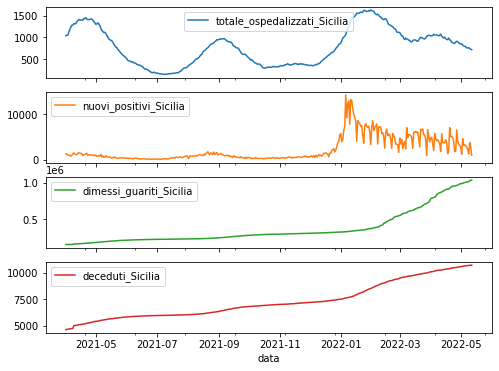

In [7]:
df_by_region["Sicilia"].plot(subplots=True)

In [8]:
regions_train = ["Sicilia"]   # name of regions to train simultaneously

NORMALIZATION = False
PCT_CHANGE = True
DIFF = False
APPLY_SMOOTHING_ORIGINAL_DATA = True
APPLY_SMOOTHING_ON_PCT = False
VALIDATION = False

all_df = dict()
all_df_1 = dict()
all_df_2 = dict()
train_df = dict() # dictionary of training dataFrames 
if VALIDATION:
    val_df = dict() # dictionary of validation dataframes
test_df = dict() # dictionary of test dataframes

OUT_STEPS = 1 # length of prediction horizon (OUTPUT OF NN)
IN_STEPS = 28 # length of input horizon (INPUT OF NN)
SHIFT = 7 # Can be different from OUT_STEPS (to be used with care)

N_BLOCK_VAL = 1

time_steps_for_test = OUT_STEPS # Numbers of days to keep out for the validation (in principle it should be of length: OUT_STEP+IN_STEPS), but we can use just OUT_STEPS
if VALIDATION:
    time_steps_for_validation = N_BLOCK_VAL * (IN_STEPS+2*SHIFT)

# FOR THE NORMALIZATION I USE THE MEANS OF TRAIN FOR BOTH TRAINING AND TESTING
for reg in regions_train:

    mean = 0
    std = 1
    
    if APPLY_SMOOTHING_ORIGINAL_DATA:
           
        window_length = 3 # MUST BE ODD; if you put 7 you obtain just the trend
        polyorder = 1 # Try also 2,  ...
        
        #df_by_region[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)] = savgol_filter(
        #         df_by_region[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)],
        #         window_length,
        #         polyorder
        #     )
        
        df_by_region[reg] = df_by_region[reg].apply(lambda col: savgol_filter(col, window_length, polyorder))


    if PCT_CHANGE:

      all_df_1[reg] = copy.deepcopy(df_by_region[reg].loc[ ((df_by_region[reg].index >= cut_date_1) & (df_by_region[reg].index <= cut_date_2)) ])
      all_df_2[reg] = copy.deepcopy(df_by_region[reg].loc[ (df_by_region[reg].index >= cut_date_3)])
      all_df_1[reg] = all_df_1[reg].pct_change().dropna()
      all_df_2[reg] = all_df_2[reg].pct_change().dropna()
      all_df[reg] = pd.concat([all_df_1[reg], all_df_2[reg]], axis = 0, ignore_index = False)
    
    if DIFF:

      all_df_1[reg] = copy.deepcopy(df_by_region[reg].loc[ ((df_by_region[reg].index >= cut_date_1) & (df_by_region[reg].index <= cut_date_2)) ])
      all_df_2[reg] = copy.deepcopy(df_by_region[reg].loc[ (df_by_region[reg].index >= cut_date_3)])
      all_df_1[reg] = all_df_1[reg].diff().dropna()
      all_df_2[reg] = all_df_2[reg].diff().dropna()
      all_df[reg] = pd.concat([all_df_1[reg], all_df_2[reg]], axis = 0, ignore_index = False)
    
    if NORMALIZATION:
      mean = all_df[reg].iloc[:-time_steps_for_test,:].mean()
      std = all_df[reg].iloc[:-time_steps_for_test,:].std()
      
    all_df[reg] = ( all_df[reg] - mean ) / std

    if APPLY_SMOOTHING_ON_PCT:
        
        window_length = 3 # MUST BE ODD; if you put 7 you obtain just the trend
        polyorder = 1 # Try also 2, 3, ...
        
        all_df[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)] = savgol_filter(
                all_df[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)],
                window_length,
                polyorder
            )
    
    if VALIDATION:
        train_df[reg] = all_df[reg].iloc[:-(time_steps_for_test + time_steps_for_validation),:]
        val_df[reg] = all_df[reg].iloc[ -(time_steps_for_test + time_steps_for_validation) : -time_steps_for_test, :]
        test_df[reg] = all_df[reg].iloc[-time_steps_for_test:,:]
    else:
        train_df[reg] = all_df[reg].iloc[:-time_steps_for_test,:]
        test_df[reg] = all_df[reg].iloc[-time_steps_for_test:,:]

    train_df[regions_train[0]] = train_df[regions_train[0]].replace([np.inf, -np.inf], np.nan).dropna()

windows = dict() # dictionary of windows for each region


# Parameters
batch_size = 8
sequence_stride = 1

for reg in regions_train:
    if VALIDATION:
        windows[reg] =  WindowGenerator(input_width=IN_STEPS,
                                        label_width=OUT_STEPS,
                                        shift=SHIFT,
                                        train_df = train_df[reg],
                                        val_df = val_df[reg],
                                        batch_size = batch_size, ### DEAFULT = 32; can be modified by hand being careful
                                        sequence_stride = sequence_stride
                                        #label_columns=['{}_{}'.format("nuovi_positivi", reg)] ### labels to train; we might split the training for the features since it may help the models...
                                        )
        windows[reg].example = windows[reg].split_window(np.row_stack([train_df, val_df]))
    else:
        windows[reg] =  WindowGenerator(input_width=IN_STEPS,
                                label_width=OUT_STEPS,
                                shift=SHIFT,
                                train_df = train_df[reg],
                                batch_size = batch_size, ### DEAFULT = 32; can be modified by hand being careful
                                sequence_stride = sequence_stride
                                #label_columns=['{}_{}'.format("nuovi_positivi", reg)] ### labels to train; we might split the training for the features since it may help the models...
                                )
        

(array([737911., 737972., 738034., 738095., 738156., 738215., 738276.]),
 <a list of 7 Text major ticklabel objects>)

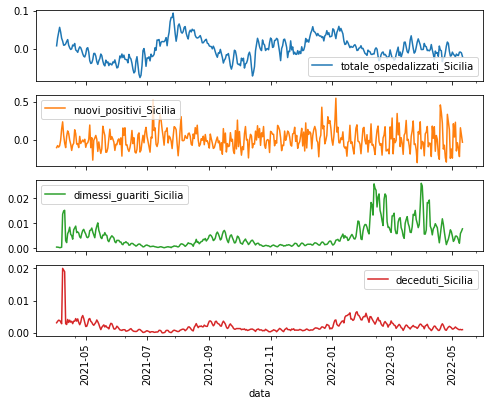

In [9]:
# check the training
train_df[regions_train[0]].plot(subplots=True)
plt.xticks(rotation=90)

Maximum number of plots will be less than:  24


<Figure size 864x576 with 0 Axes>

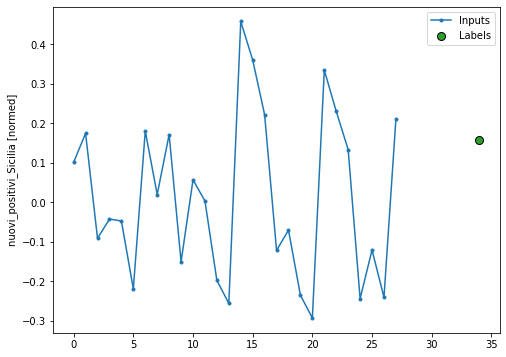

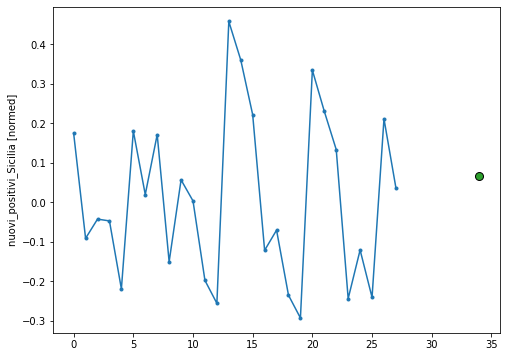

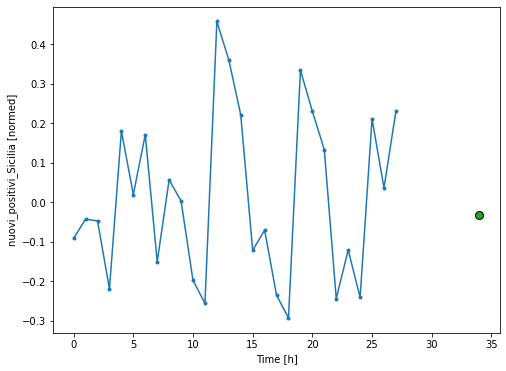

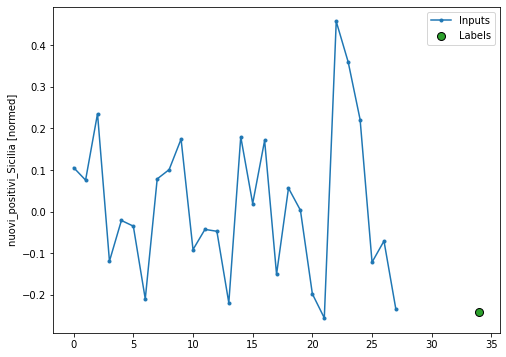

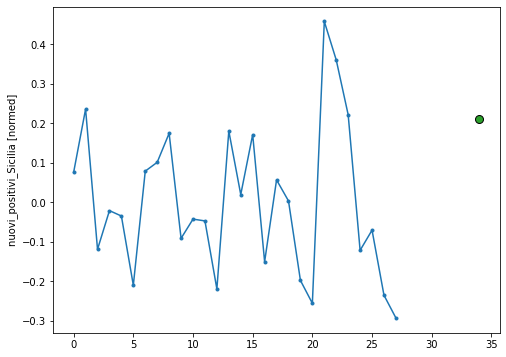

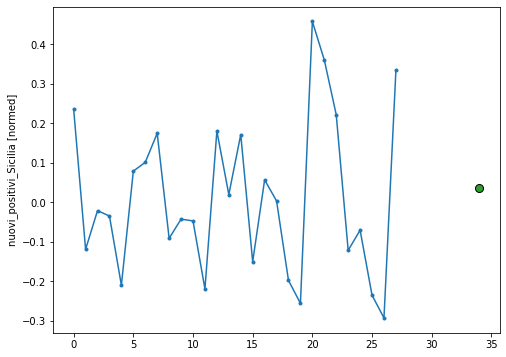

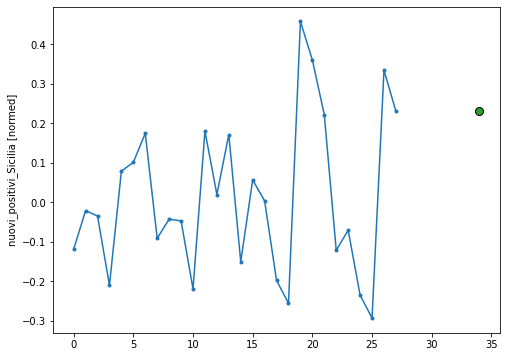

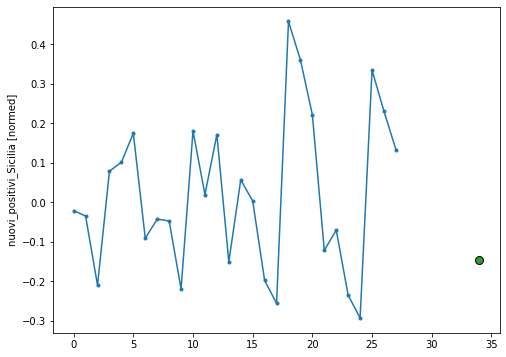

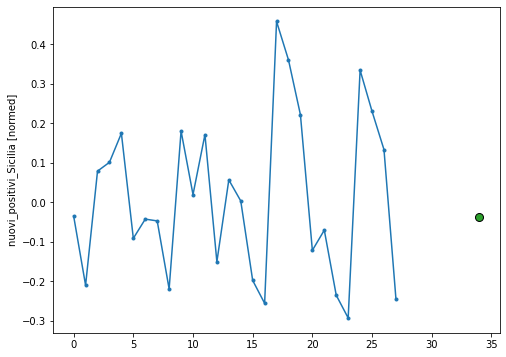

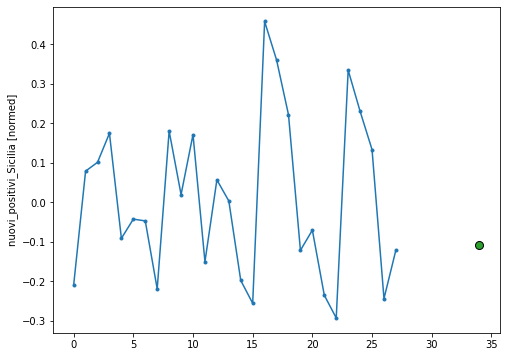

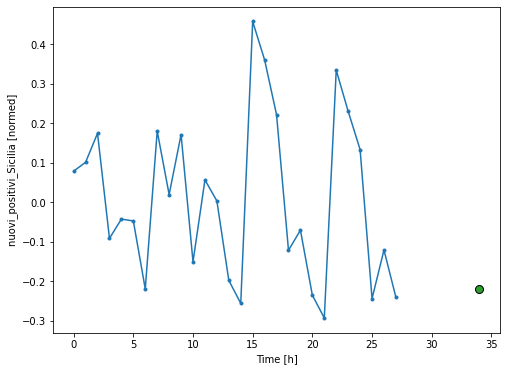

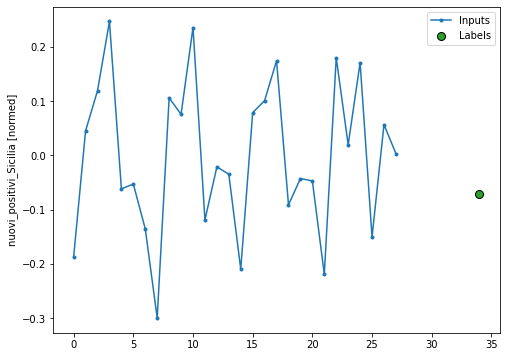

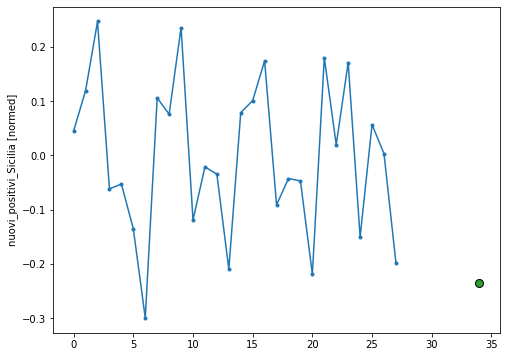

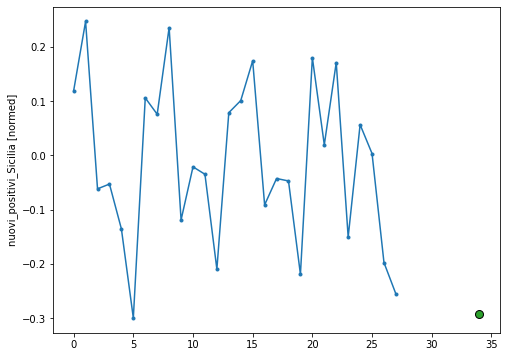

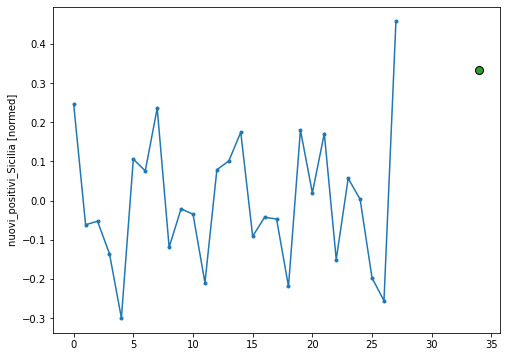

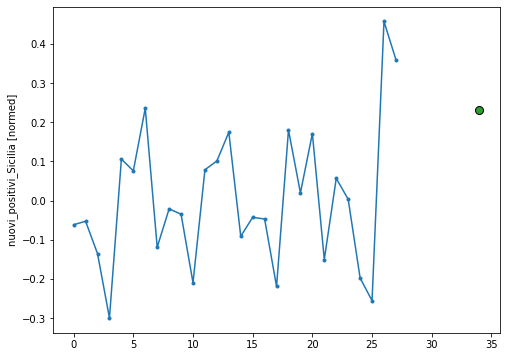

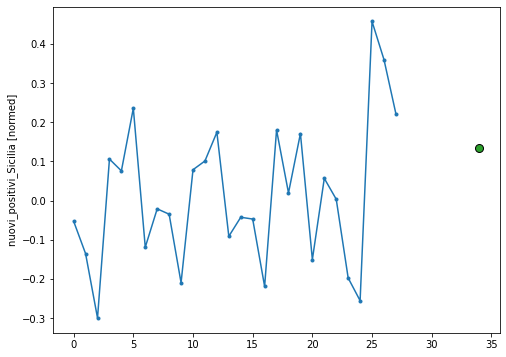

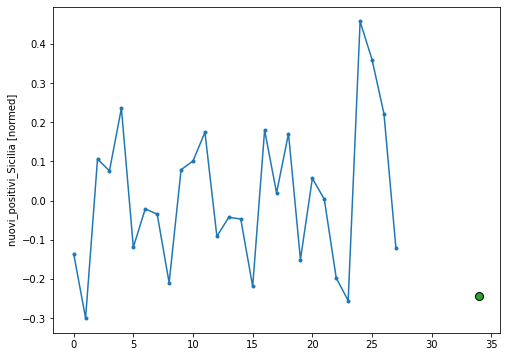

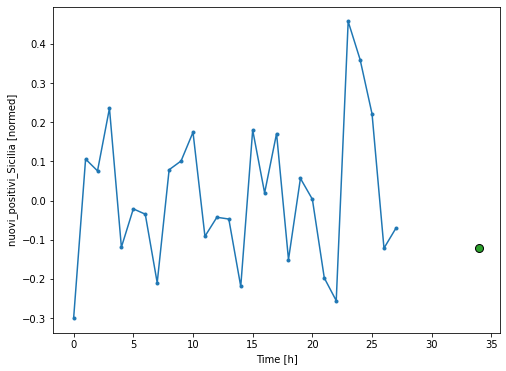

In [10]:
# Plot for viewing the batches
# region = regions_train[0] # modify by hand for groups
# feature = "nuovi_positivi" #nuovi_positivi, dimessi_guariti, #totale_ospedalizzati
# plot_feature(region, feature, max_figures=40)

windows["Sicilia"].plot_all_predictions(plot_col = "nuovi_positivi_Sicilia")

In [11]:
# Creation Training set for RNN

# Single region
if len(regions_train) == 1:

    X_train = windows[regions_train[0]].train
    
    try:
        X_val =  windows[regions_train[0]].val
    except:
        print("Cannot create X_val for trainf with the given window size or val_df not present")
        X_val = None

# Multiple regions
elif len(regions_train) > 1:
    
    print("More than one region...")
    
    for i in range(len(regions_train)-1):
        
        X_train = windows[regions_train[i]].train.concatenate(windows[regions_train[i+1]].train)
        
        try:
            X_val = windows[regions_train[i]].val.concatenate(windows[regions_train[i+1]].val)
        except:
            print("Cannot create X_val for trainf with the given window size or val_df not present")
            X_val = None

Cannot create X_val for trainf with the given window size or val_df not present


In [12]:
# IN THIS WAY YOU CAN EXTRACT THE TRAINING DATASET (Solution to the problem highlighted by Nove)
# list(X_train.as_numpy_iterator())

## Multi-Steps

In [13]:
def compile_and_fit(model, X_train, MAX_EPOCHS = 200, X_val = None, patience=30, custom_loss = None):
    
    if custom_loss == None:
    
        if X_val == None:
            monitor_loss = 'loss'
        else:
            monitor_loss = 'val_loss'
    else:
        monitor_loss = custom_loss
    
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor_loss, 
                                                    patience=patience,
                                                    mode='min')
  
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor_loss, 
                                                   factor=0.2,
                                                   patience=patience, 
                                                   min_lr=0.0001)
  
    #easy_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/Othercomputers/Laptop/homework3/Data/checkpoint_' + reg + '.h5',
    #                                                     save_weights_only = False, save_freq = 'epoch', monitor = monitor_loss, mode='min', 
    #                                                     save_best_only = True, verbose = 1)

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(X_train, epochs=MAX_EPOCHS,
                          validation_data=X_val,
                          callbacks=[early_stopping, reduce_lr])    #callbacks= [early_stopping, easy_checkpoint])

    return history

In [14]:
# # Run if we want to start from an old model
# multi_lstm_model = tf.keras.models.load_model('/content/drive/Othercomputers/Laptop/homework3/Data/checkpoint_' + reg + '.h5')

In [15]:
# Current best model for Sicilia

num_features = 4

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4)), #activation='selu'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [16]:
if VALIDATION:
    history = compile_and_fit(multi_lstm_model, X_train, X_val = X_val, MAX_EPOCHS = 500, patience = 15)
else:
    history = compile_and_fit(multi_lstm_model, X_train, MAX_EPOCHS = 500, patience = 15)

Epoch 1/500
47/47 [==============================] - 8s 26ms/step - loss: 0.0095 - mean_absolute_error: 0.0334 - lr: 0.0010
Epoch 2/500
47/47 [==============================] - 1s 14ms/step - loss: 0.0074 - mean_absolute_error: 0.0334 - lr: 0.0010
Epoch 3/500
47/47 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_absolute_error: 0.0334 - lr: 0.0010
Epoch 4/500
47/47 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_absolute_error: 0.0335 - lr: 0.0010
Epoch 5/500
47/47 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_absolute_error: 0.0335 - lr: 0.0010
Epoch 6/500
47/47 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_absolute_error: 0.0334 - lr: 0.0010
Epoch 7/500
47/47 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_absolute_error: 0.0332 - lr: 0.0010
Epoch 8/500
47/47 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_absolute_error: 0.0328 - lr: 0.0010
Epoch 9/

Maximum number of plots will be less than:  24


<Figure size 864x576 with 0 Axes>

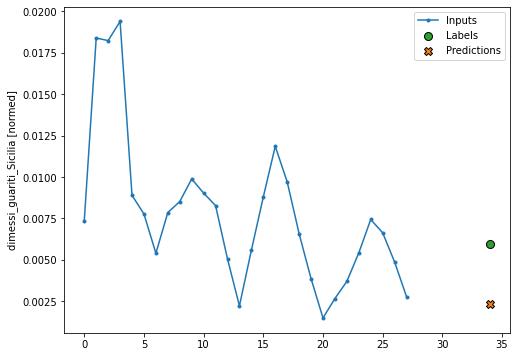

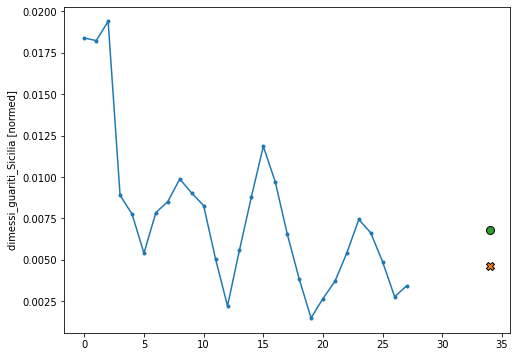

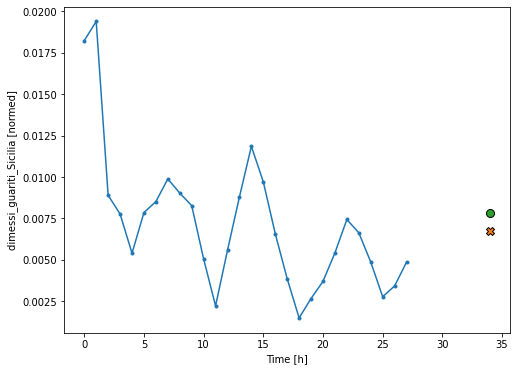

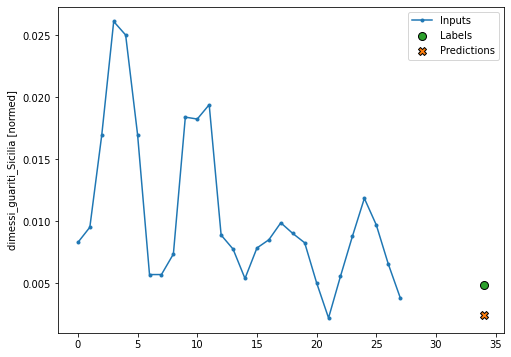

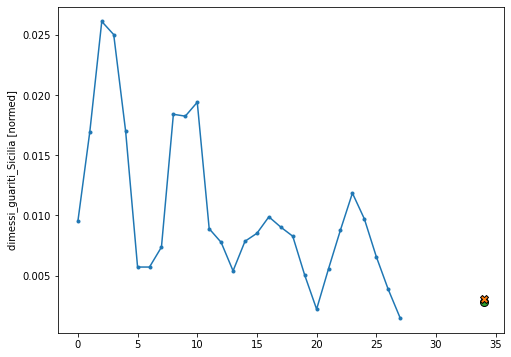

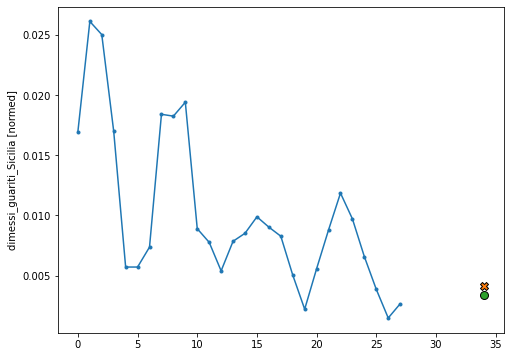

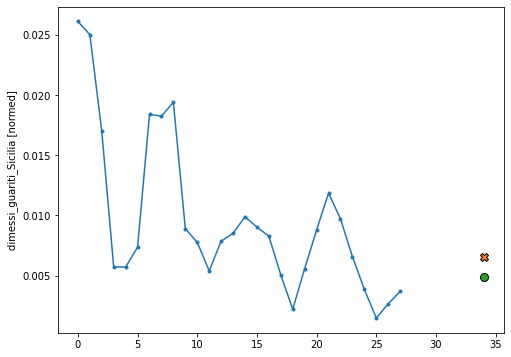

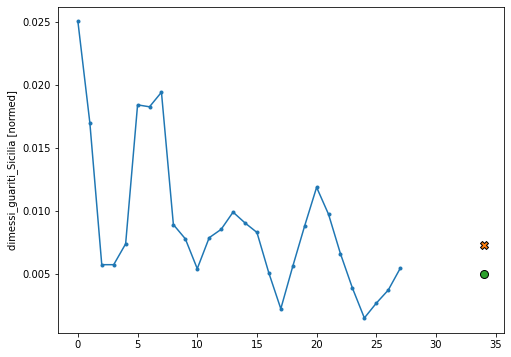

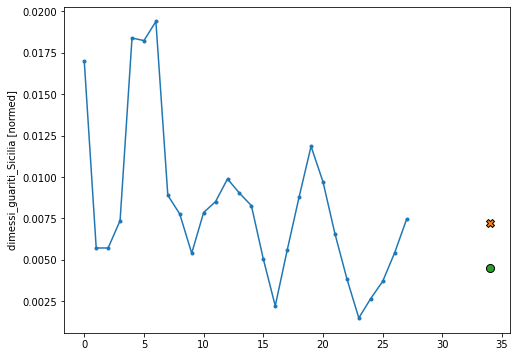

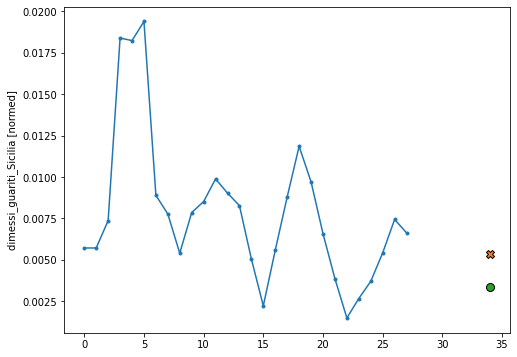

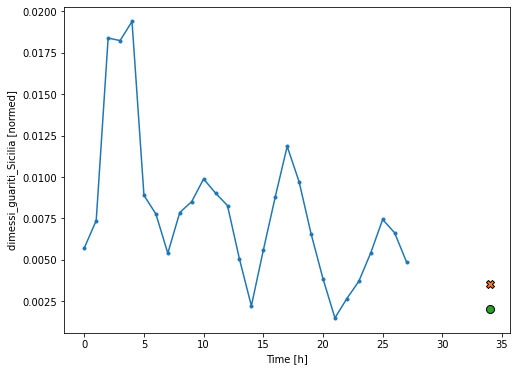

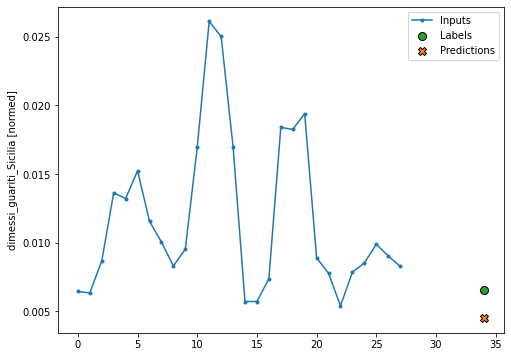

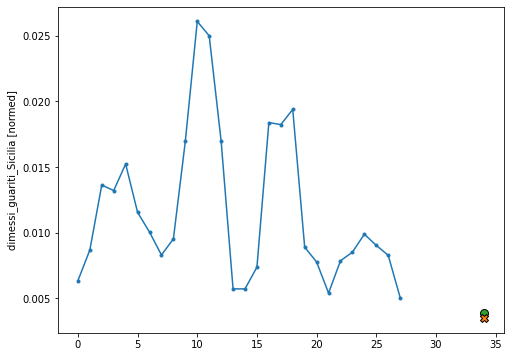

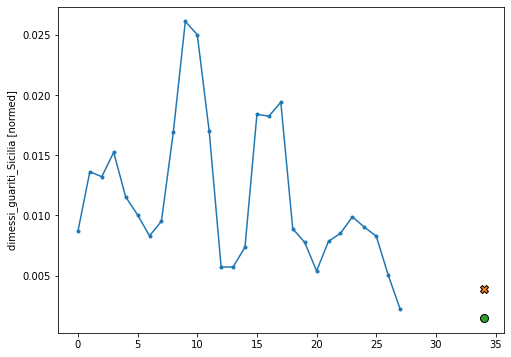

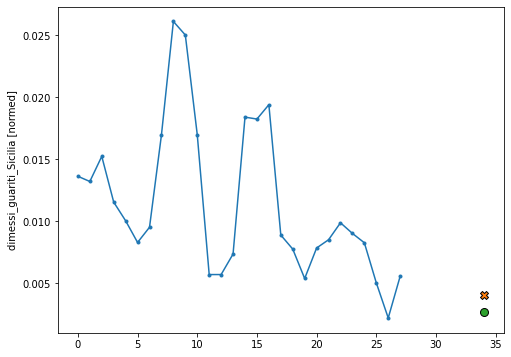

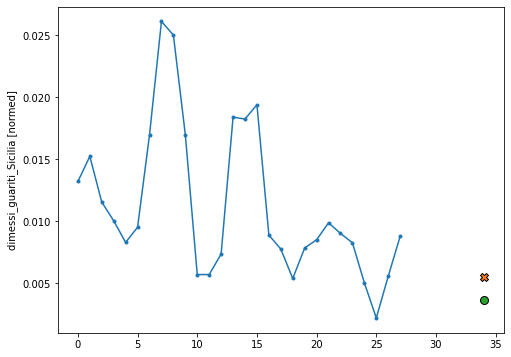

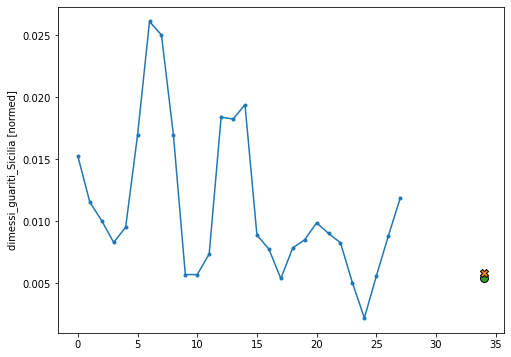

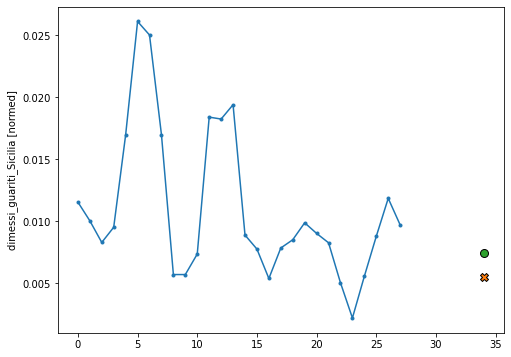

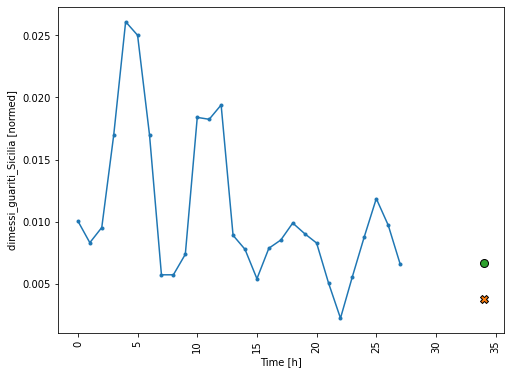

In [17]:
region = regions_train[0]
feature = "dimessi_guariti"  #nuovi_positivi, dimessi_guariti, #totale_ospedalizzati #deceduti
# more_recent = true => I plot the more recent days first
plot_feature(region, feature, multi_lstm_model, more_recent = True)

Maximum number of plots will be less than:  24


<Figure size 864x576 with 0 Axes>

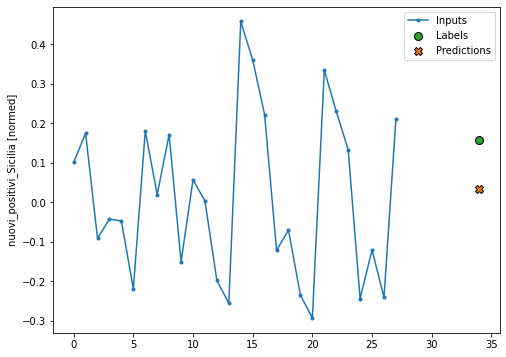

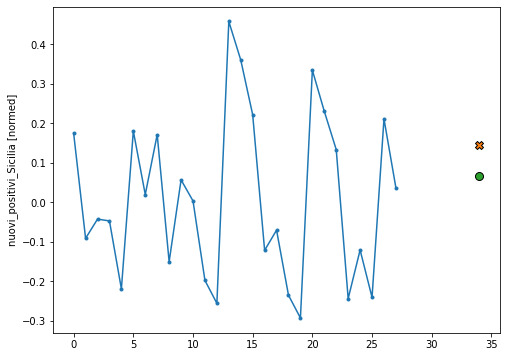

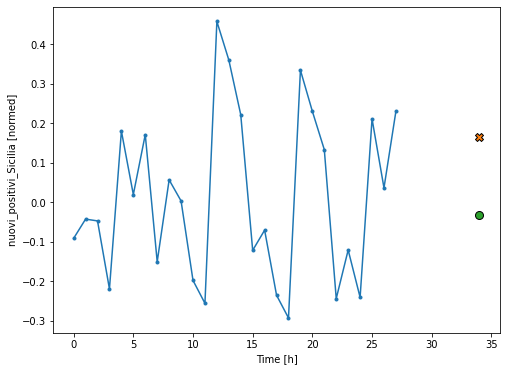

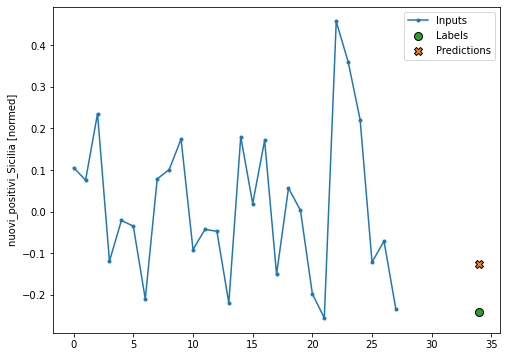

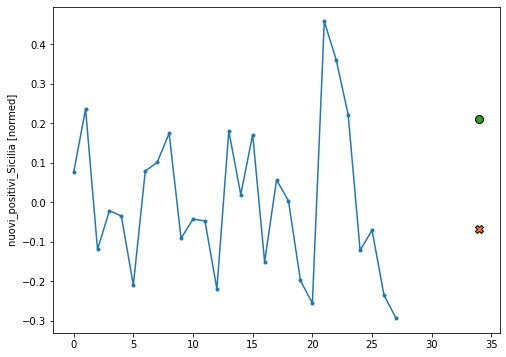

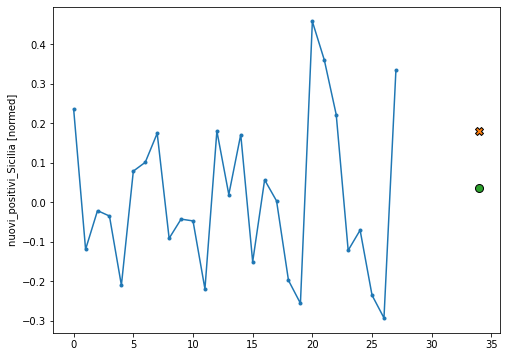

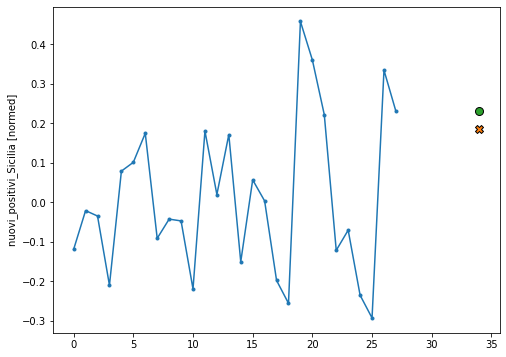

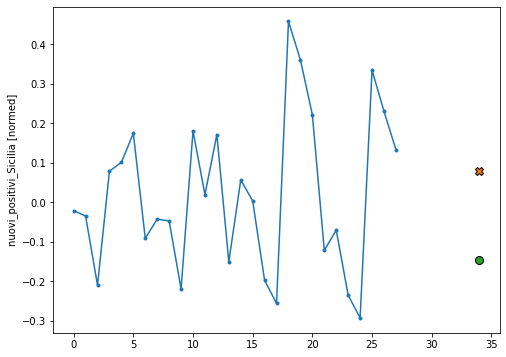

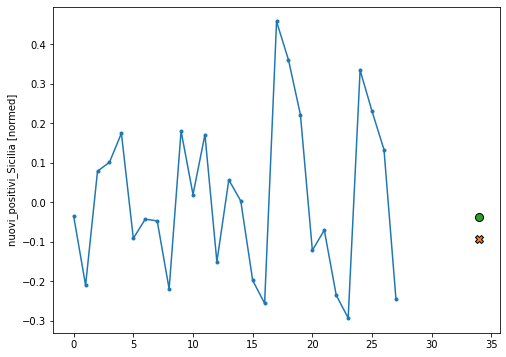

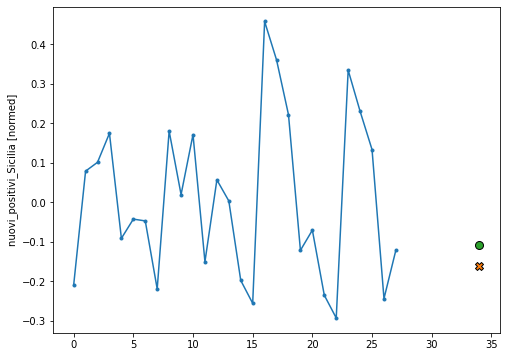

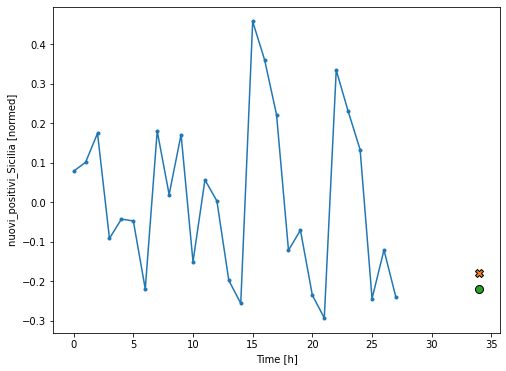

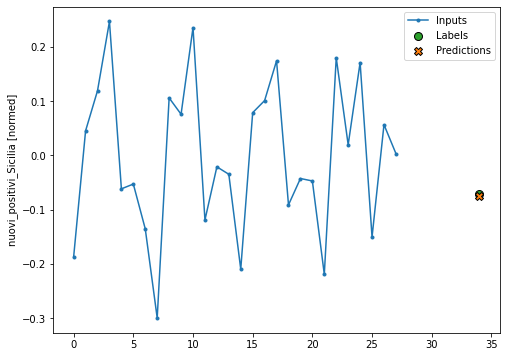

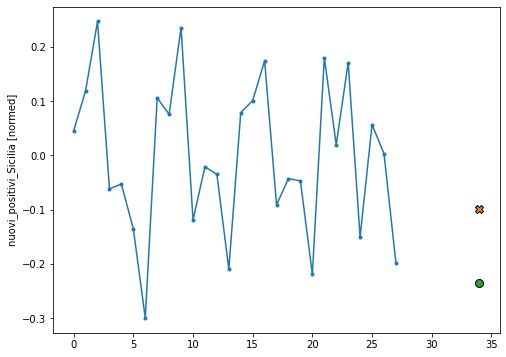

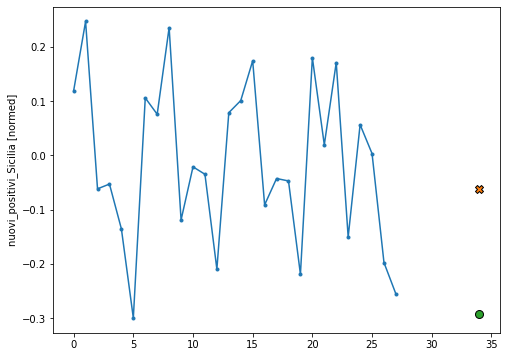

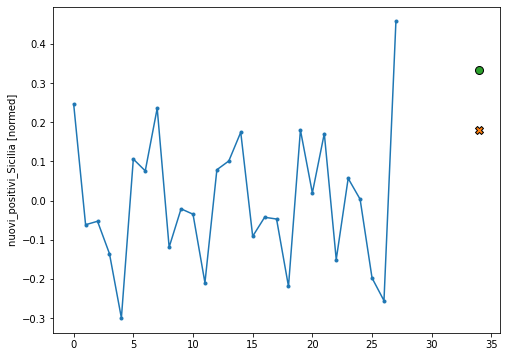

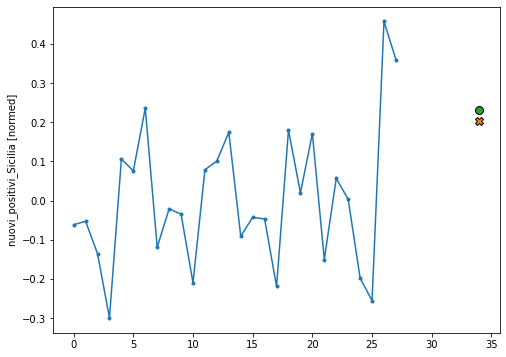

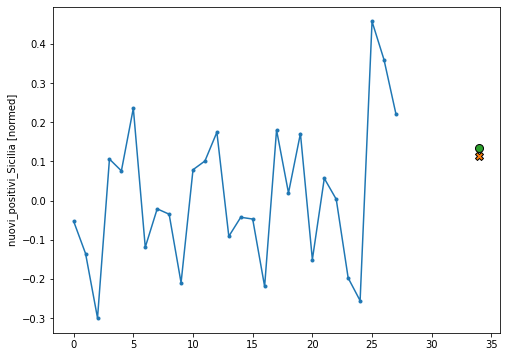

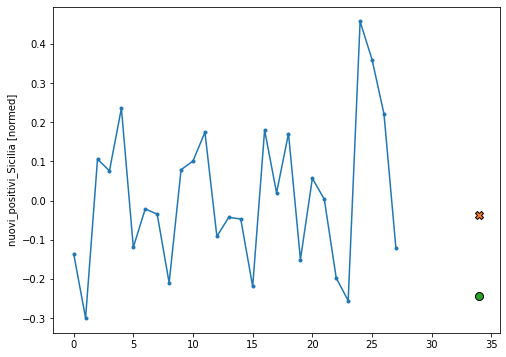

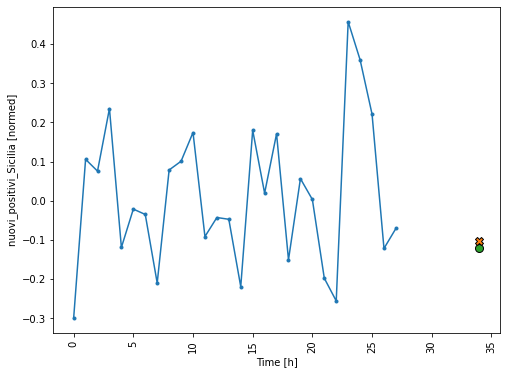

In [18]:
region = regions_train[0]
feature = "nuovi_positivi"  #nuovi_positivi, dimessi_guariti, #totale_ospedalizzati #deceduti
# more_recent = true => I plot the more recent days first
plot_feature(region, feature, multi_lstm_model, more_recent = True)

In [19]:
region = regions_train[0]

predictions_df = pd.DataFrame()

for i in range(-5,2,1):
        
    if VALIDATION:
        pred_x_predict = multi_lstm_model(np.array(val_df[reg].iloc[-(IN_STEPS+SHIFT-i):-(SHIFT-i),:]).reshape(1, IN_STEPS, 4)) 
        predictions_df = pd.concat([predictions_df, pd.DataFrame(pred_x_predict[0].numpy())], axis = 0)
    else:
        pred_x_predict = multi_lstm_model(np.array(train_df[reg].iloc[-(IN_STEPS+SHIFT-i):-(SHIFT-i),:]).reshape(1, IN_STEPS, 4))
        predictions_df = pd.concat([predictions_df, pd.DataFrame(pred_x_predict[0].numpy())], axis = 0)

pred_x_predict_true = np.array(predictions_df.iloc[-1,:])

In [20]:
pr = tf.squeeze(pred_x_predict_true)
prd = pd.DataFrame(pred_x_predict_true.reshape(OUT_STEPS,4))

idx = test_df[reg].index

predictions = prd.rename(columns={0: 'pred_totale_ospedalizzati_' + reg, 
                                  1: 'pred_nuovi_positivi_' + reg,
                                  2: 'pred_dimessi_guariti_' + reg,
                                  3: 'pred_deceduti_' + reg})

predictions.index = test_df[reg].index

In [21]:
concatenated_df = pd.concat([predictions, test_df[reg]], axis=1)

errors = pd.DataFrame()
for i in range(4):
  errors = pd.concat([errors, concatenated_df.iloc[:, i] - concatenated_df.iloc[:, i+4]], axis = 1, ignore_index=True)

### Back to original scale

In [22]:
init = df_by_region[reg].iloc[-time_steps_for_test-SHIFT,:]
init = pd.DataFrame(init).T

initial = init.rename(columns={'totale_ospedalizzati_' + reg: 'pred_totale_ospedalizzati_' + reg, 
                               'nuovi_positivi_' + reg: 'pred_nuovi_positivi_' + reg,
                               'dimessi_guariti_' + reg: 'pred_dimessi_guariti_' + reg,
                               'deceduti_' + reg: 'pred_deceduti_' + reg} )

predictions_df.columns = initial.columns

pred_original_scale = (1 + predictions_df).cumprod() * initial.iloc[0,:]

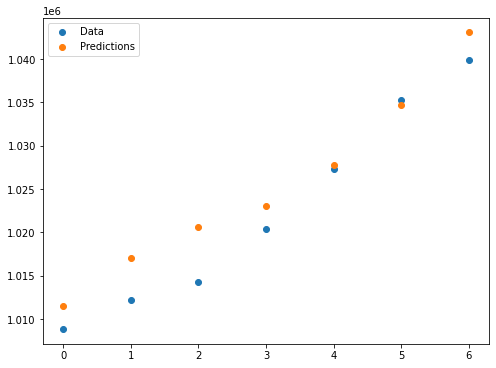

In [23]:
plot_predictions( 'Sicilia', 'dimessi_guariti', original = True)   #nuovi_positivi, dimessi_guariti, totale_ospedalizzati, deceduti


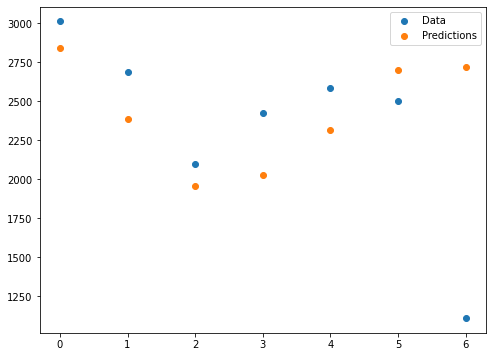

In [24]:
plot_predictions( 'Sicilia', 'nuovi_positivi', original = True)   #nuovi_positivi, dimessi_guariti, totale_ospedalizzati, deceduti
                                                                    # Original = False if we want to plot the pred in pct_change scale

In [25]:
# Error with original data

idx_true = df_by_region[reg].iloc[-time_steps_for_test:,:].index
idx_pred = predictions.index
true_test = df_by_region[reg].iloc[-time_steps_for_test:,:]
true_test.index = idx_pred


GIUSTO = pd.DataFrame(np.array(pred_original_scale.iloc[-1,:]).reshape(OUT_STEPS,4), columns=pred_original_scale.columns)
GIUSTO.index = true_test.index

original_concatenated_df = pd.concat([GIUSTO, true_test], axis=1 )


original_errors = pd.DataFrame()
for i in range(4):
  original_errors = pd.concat([original_errors, original_concatenated_df.iloc[:, i] - original_concatenated_df.iloc[:, i+4]], axis = 1, ignore_index=True)

original_err = original_errors.rename(columns={0: 'totale_ospedalizzati_' + reg, 
                                               1: 'nuovi_positivi_' + reg,
                                               2: 'dimessi_guariti_' + reg,
                                               3: 'deceduti_' + reg} )

original_error = (original_err * std) + mean

original_error_perc = (original_error / true_test) * 100

In [26]:
original_error_perc # percentage error on ture values

,totale_ospedalizzati_Sicilia,nuovi_positivi_Sicilia,dimessi_guariti_Sicilia,deceduti_Sicilia
2022-05-12,8.678428,144.512774,0.305243,0.71979


In [27]:
original_error

,totale_ospedalizzati_Sicilia,nuovi_positivi_Sicilia,dimessi_guariti_Sicilia,deceduti_Sicilia
2022-05-12,62.209866,1606.741193,3174.162806,77.277888


# CSV creation for webeep

In [28]:
region = regions_train[0]

new_all_predictions_df = pd.DataFrame()

for i in range(6,-1,-1):
    
    if i==0:
        pred_x_predict = multi_lstm_model(np.array(all_df[reg].iloc[-IN_STEPS:,:]).reshape(1, IN_STEPS, 4)) 
        new_all_predictions_df = pd.concat([new_all_predictions_df, pd.DataFrame(pred_x_predict[0].numpy())], axis = 0)
    else:
        pred_x_predict = multi_lstm_model(np.array(all_df[reg].iloc[-(IN_STEPS+i):-i,:]).reshape(1, IN_STEPS, 4))
        new_all_predictions_df = pd.concat([new_all_predictions_df, pd.DataFrame(pred_x_predict[0].numpy())], axis = 0)
       
new_pred_x_predict_true = np.array(predictions_df.iloc[-1,:])

In [29]:
(all_df[reg].iloc[-(IN_STEPS):,:]).shape

(28, 4)

In [30]:
pr = tf.squeeze(new_pred_x_predict_true)
prd = pd.DataFrame(new_pred_x_predict_true.reshape(OUT_STEPS,4))

new_predictions = prd.rename(columns={0: 'pred_totale_ospedalizzati_' + reg, 
                                  1: 'pred_nuovi_positivi_' + reg,
                                  2: 'pred_dimessi_guariti_' + reg,
                                  3: 'pred_deceduti_' + reg})


In [31]:
new_init = df_by_region[reg].iloc[-1,:]
new_init = pd.DataFrame(new_init).T

new_initial = new_init.rename(columns={'totale_ospedalizzati_' + reg: 'pred_totale_ospedalizzati_' + reg, 
                                       'nuovi_positivi_' + reg: 'pred_nuovi_positivi_' + reg,
                                       'dimessi_guariti_' + reg: 'pred_dimessi_guariti_' + reg,
                                       'deceduti_' + reg: 'pred_deceduti_' + reg} )


new_all_predictions_df.columns = initial.columns

new_pred_orig_scale = (1 + new_all_predictions_df).cumprod() * new_initial.iloc[0,:]

In [32]:
new_final_predictions = pd.DataFrame(np.array(new_pred_orig_scale.iloc[-1,:]).reshape(OUT_STEPS,4), columns=pred_original_scale.columns)

In [33]:
new_final_predictions.columns = ['hospitalized', 'newinfections', 'recovered', 'deceased']
new_final_predictions = new_final_predictions[['newinfections', 'hospitalized' , 'recovered' , 'deceased']]

In [34]:
new_final_predictions.index = [ regions_train[0] ]

In [35]:
new_final_predictions.to_csv('webeepUpload_' + reg +  '.csv', index=True)

In [36]:
new_final_predictions.to_csv('/content/drive/Othercomputers/Laptop/homework3/scripts/webeepUpload_' + reg +  '.csv', index=True)

In [37]:
new_pred_orig_scale

,pred_totale_ospedalizzati_Sicilia,pred_nuovi_positivi_Sicilia,pred_dimessi_guariti_Sicilia,pred_deceduti_Sicilia
0,703.629619,1029.072036,1.047481e+06,10759.280772
0,698.644621,886.746743,1.053310e+06,10777.985792
0,697.573679,747.124355,1.057367e+06,10794.401158
0,701.110758,761.860977,1.060353e+06,10811.585715
0,696.918381,862.777457,1.065229e+06,10835.195122
0,679.563564,945.338485,1.072830e+06,10863.275049
0,644.850170,839.483135,1.082936e+06,10892.255990


In [38]:
pred_original_scale

,pred_totale_ospedalizzati_Sicilia,pred_nuovi_positivi_Sicilia,pred_dimessi_guariti_Sicilia,pred_deceduti_Sicilia
0,786.592167,2839.999712,1.011556e+06,10682.377645
0,787.771028,2385.586141,1.016984e+06,10699.488911
0,793.375382,1957.141006,1.020596e+06,10714.934040
0,805.587480,2025.145516,1.022995e+06,10731.728854
0,806.761792,2317.537210,1.027730e+06,10756.784455
0,798.548620,2702.500916,1.034634e+06,10785.781087
0,779.043200,2718.574526,1.043054e+06,10813.444555
